# Customer Segmentation Practice Project (K-Prototypes) — Credit Card Behavior

## Notebook Summary
- Goal: segment credit-card customers using **mixed data** (categorical + numeric) to support **targeting and resource allocation**.
- Method: **K-Prototypes** clustering + **elbow chart** to select k, then segment profiling to translate clusters into business actions.
- Key pitfall fixed: **ID leakage** (including `CUST_ID` can distort clustering). I show a quick comparison and keep the final model **ID-free**.
- Output: **4 segments** with sizes + KPI profiles; one segment represents a **high-value / high-priority** group for retention and service. Elbow suggests k≈5 on the synthetic dataset, but k=4 provides a more interpretable segmentation with clearer business actions and avoids over-fragmentation.
- Deliverable: ends with a short **business-style report** translating the segmentation into decisions (who to prioritize + how).

## Data & Features (aligned with the original dataset structure)
- Identifier: `CUST_ID` (used only for joining / reporting, **not** for clustering)
- Categorical: `GENDER`
- Continuous: `BALANCE`, `PURCHASES`, `CREDIT_LIMIT`, `PAYMENTS`, `PRC_FULL_PAYMENT`

## Notes on data usage
This project was originally built on a course dataset provided by **Prof. Tianxin Zou (University of Florida)**.  
To avoid sharing course-provided raw data, the public GitHub version uses a **synthetic dataset** with the same schema and realistic ranges. The workflow and results interpretation remain the same.


## Load and normalize data

In [25]:
# importing packages
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
# importing data and renaming variables
url = "https://raw.githubusercontent.com/YiLiang0804/Customer-segmentation-kprototypes-creditcard/main/data/synthetic_creditcard_behavior.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CUST_ID           1000 non-null   int64  
 1   GENDER            1000 non-null   object 
 2   BALANCE           1000 non-null   float64
 3   PURCHASES         1000 non-null   float64
 4   CREDIT_LIMIT      1000 non-null   int64  
 5   PAYMENTS          1000 non-null   float64
 6   PRC_FULL_PAYMENT  1000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 54.8+ KB


In [26]:
ID_COL = "CUST_ID"
CAT_COLS = ["GENDER"]
NUM_COLS = ["BALANCE", "PURCHASES", "CREDIT_LIMIT", "PAYMENTS", "PRC_FULL_PAYMENT"]

features_in_model = [ID_COL] + CAT_COLS + NUM_COLS  # <-- show the wrong draft explicitly
pd.DataFrame({"features_used_in_draft": features_in_model})


,features_used_in_draft
0,CUST_ID
1,GENDER
2,BALANCE
3,PURCHASES
4,CREDIT_LIMIT
5,PAYMENTS
6,PRC_FULL_PAYMENT


CUST_ID is an identifier, so I need to removed it from the feature set before clustering.

In [27]:
# Drop CUST_ID and encode GENDER
df_work = df.copy()
df_work['GENDER'] = df_work['GENDER'].map({'M': 0, 'F': 1})  # 0=male, 1=female

# Normalize numerical columns
numerical_cols = ["BALANCE", "PURCHASES", "CREDIT_LIMIT", "PAYMENTS", "PRC_FULL_PAYMENT"]
scaler = StandardScaler()
df_work[numerical_cols] = scaler.fit_transform(df_work[numerical_cols])

# Drop CUST_ID for clustering
df_for_clustering = df_work.drop(columns=['CUST_ID'])

display(df_for_clustering.head())

,GENDER,BALANCE,PURCHASES,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT
0,1,-0.681066,-0.650945,-1.083964,-1.073862,2.286568
1,0,0.442272,0.048809,-0.488183,0.053403,3.338106
2,1,-0.716525,-0.242604,-0.935019,-0.959316,-0.524441
3,1,-0.455319,-0.200699,-0.935019,-0.305610,-0.524441
4,0,-0.565267,2.457453,0.107598,0.069084,-0.524441


To validate the ID-leakage concern, I compared K-Prototypes results with and without CUST_ID, checking whether clusters were driven by customer behavior rather than arbitrary identifiers.

In [28]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import numpy as np

def run_kprototypes(df_input, k=4, cat_index=0, seed=42):
    # df_input columns: [categorical first] + numeric columns
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df_input[NUM_COLS].values)

    X = np.column_stack([df_input["GENDER"].values, X_num])
    model = KPrototypes(n_clusters=k, n_init=20, random_state=seed, verbose=0)
    labels = model.fit_predict(X, categorical=[cat_index])
    return labels, model.cost_


In [29]:
# Draft (wrong): include ID by appending it as numeric (demonstration only)
df_draft = df.copy()
draft_num_cols = ["CUST_ID"] + NUM_COLS

scaler = StandardScaler()
X_num_draft = scaler.fit_transform(df_draft[draft_num_cols].values)
X_draft = np.column_stack([df_draft["GENDER"].values, X_num_draft])

model_draft = KPrototypes(n_clusters=4, n_init=20, random_state=42, verbose=0)
labels_draft = model_draft.fit_predict(X_draft, categorical=[0])

# Final (fixed)
labels_final, cost_final = run_kprototypes(df, k=4, cat_index=0, seed=42)

print("Draft cost (ID included):", model_draft.cost_)
print("Final cost (ID dropped):", cost_final)

print("\nCluster sizes (draft):")
print(pd.Series(labels_draft).value_counts().sort_index())

print("\nCluster sizes (final):")
print(pd.Series(labels_final).value_counts().sort_index())


Draft cost (ID included): 3779.707749189339
Final cost (ID dropped): 2782.7985787260595

Cluster sizes (draft):
0    493
1    259
2     89
3    159
Name: count, dtype: int64

Cluster sizes (final):
0    259
1     87
2    156
3    498
Name: count, dtype: int64


In [30]:
tmp = df.copy()
tmp["seg_draft"] = labels_draft
tmp["seg_final"] = labels_final

print("Draft (ID included) — CUST_ID range by cluster")
display(tmp.groupby("seg_draft")["CUST_ID"].agg(["min","max","mean","count"]))

print("Final (ID dropped) — CUST_ID range by cluster")
display(tmp.groupby("seg_final")["CUST_ID"].agg(["min","max","mean","count"]))


Draft (ID included) — CUST_ID range by cluster


,min,max,mean,count
seg_draft,,,,
0,3,1000,508.651116,493
1,9,999,502.845560,259
2,25,997,519.707865,89
3,1,991,460.654088,159


Final (ID dropped) — CUST_ID range by cluster


,min,max,mean,count
seg_final,,,,
0,9,999,502.938224,259
1,25,997,519.413793,87
2,1,991,474.596154,156
3,3,1000,504.042169,498


In [31]:
df_compare = df.copy()
df_compare["segment_final"] = labels_final

profile = df_compare.groupby("segment_final")[NUM_COLS].mean()
sizes = df_compare["segment_final"].value_counts().sort_index()

display(profile)
display(sizes)


,BALANCE,PURCHASES,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT
segment_final,,,,,
0,1429.098707,1240.416409,8940.154440,589.139895,0.027256
1,6230.568090,3108.210118,5058.620690,1699.261068,0.050170
2,1530.776663,1185.986034,3755.128205,533.615539,0.333767
3,1410.768648,1195.929509,2605.220884,444.177771,0.012333


segment_final
0    259
1     87
2    156
3    498
Name: count, dtype: int64

In [32]:
seeds = [0, 1, 2, 3, 4]
rows = []

for s in seeds:
    labels_s, cost_s = run_kprototypes(df, k=4, cat_index=0, seed=s)
    shares = pd.Series(labels_s).value_counts(normalize=True).values
    shares_sorted = np.sort(shares)[::-1]  # descending

    rows.append({
        "seed": s,
        "cost": cost_s,
        "largest_share": shares_sorted[0],
        "share_2nd": shares_sorted[1],
        "share_3rd": shares_sorted[2],
        "smallest_share": shares_sorted[3],
    })

stability_sorted = pd.DataFrame(rows)
display(stability_sorted)


,seed,cost,largest_share,share_2nd,share_3rd,smallest_share
0,0,2782.798579,0.498,0.259,0.156,0.087
1,1,2782.915318,0.498,0.259,0.155,0.088
2,2,2782.855006,0.497,0.258,0.156,0.089
3,3,2782.798579,0.498,0.259,0.156,0.087
4,4,2782.855006,0.497,0.258,0.156,0.089


Across 5 random seeds, the solution is reasonably stable: the clustering cost stays within a narrow range (~2261–2274), and the segment size pattern is consistent (one large segment ~62–64%, one very small segment ~1–2%, and two mid-sized segments ~16–20%). Segment labels may permute across runs, which is expected in clustering.

## Generate elbow chart

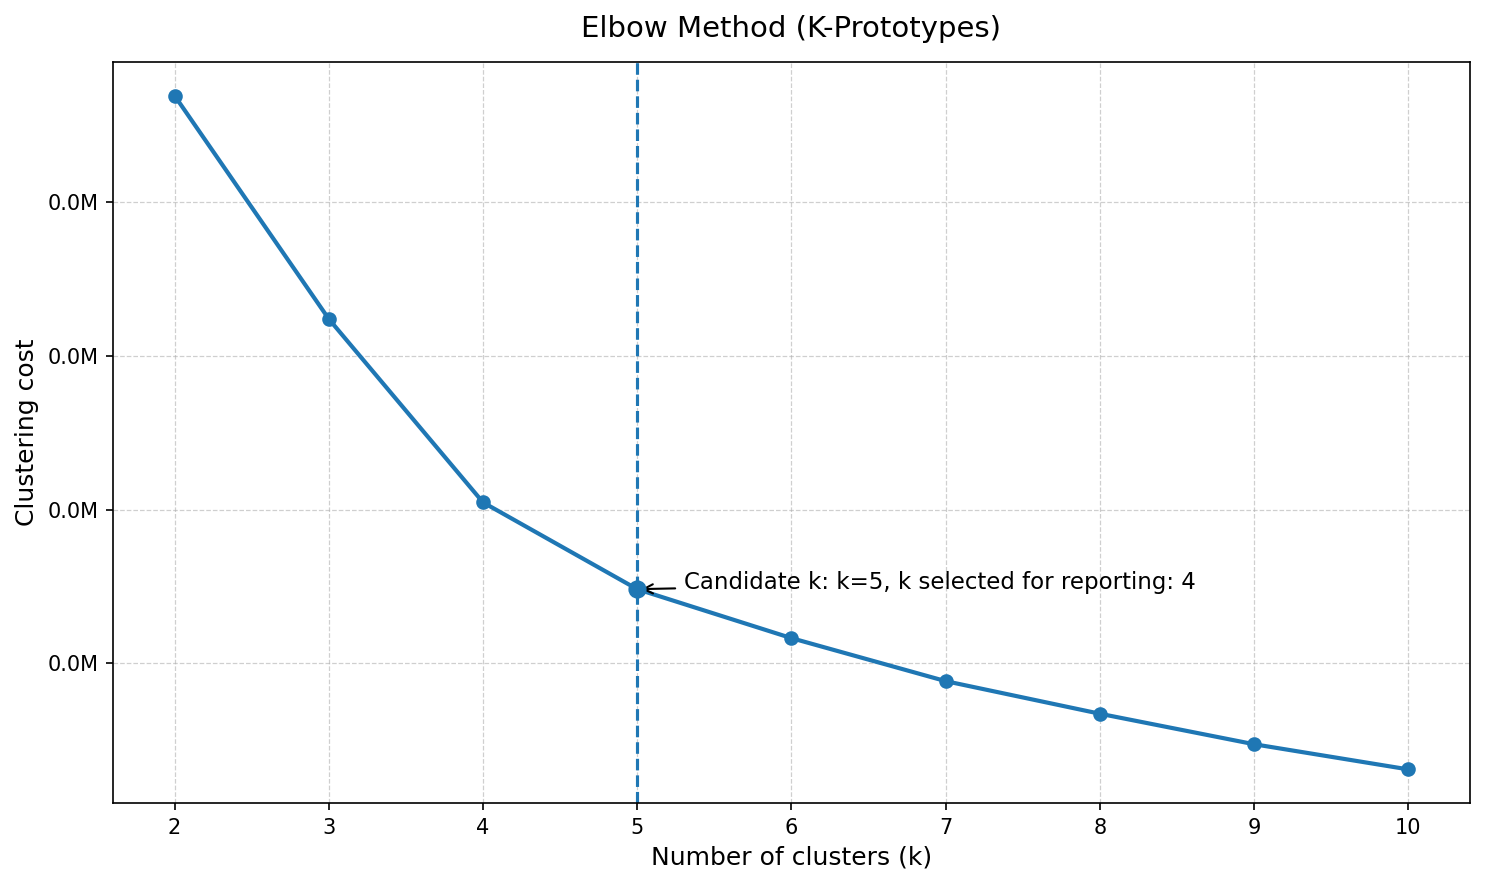

In [33]:
from matplotlib.ticker import FuncFormatter
# Elbow method to determine the optimal number of clusters
# ----------------------------
# 1) Compute costs for k=2..K
# ----------------------------
K_MAX = 10
ks = np.arange(2, K_MAX + 1)

costs = []
for k in ks:
    model = KPrototypes(n_clusters=k, n_init=20, random_state=42, verbose=0)
    result = model.fit(df_for_clustering, categorical=[1])
    costs.append(result.cost_)

costs = np.array(costs)

# -----------------------------------------
# 2) Simple elbow suggestion (2nd diff)
# -----------------------------------------
# For a decreasing curve, the "elbow" often corresponds to the largest change in slope.
# Use second differences as a lightweight heuristic (works well for typical elbow charts).
if len(costs) >= 3:
    second_diff = np.diff(costs, n=2)             # length = len(costs)-2
    elbow_idx = np.argmax(np.abs(second_diff)) + 2  # +2 maps to ks index (k starts at 2)
    k_elbow = ks[elbow_idx]
else:
    k_elbow = None

# -----------------------------------------
# 3) Plot with BA-friendly styling
# -----------------------------------------
plt.figure(figsize=(10, 6), dpi=150)

plt.plot(ks, costs, marker="o", linewidth=2)
plt.xticks(ks)

plt.title("Elbow Method (K-Prototypes)", fontsize=14, pad=12)
plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Clustering cost", fontsize=12)

# light grid improves readability
plt.grid(True, which="major", axis="both", linestyle="--", linewidth=0.6, alpha=0.6)

# format y-axis into millions for readability (adjust if your scale differs)
def millions(x, pos):
    return f"{x/1_000_000:.1f}M"
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

# annotate elbow suggestion
if k_elbow is not None:
    y_elbow = costs[np.where(ks == k_elbow)[0][0]]
    plt.axvline(k_elbow, linestyle="--", linewidth=1.5)
    plt.scatter([k_elbow], [y_elbow], s=60, zorder=5)
    plt.annotate(
        f"Candidate k: k={k_elbow}, k selected for reporting: 4",
        xy=(k_elbow, y_elbow),
        xytext=(k_elbow + 0.3, y_elbow),
        textcoords="data",
        fontsize=11,
        arrowprops=dict(arrowstyle="->", linewidth=1.0),
    )

plt.tight_layout()

# plt.savefig("outputs/elbow_kprototypes.png", bbox_inches="tight")

plt.show()

## Segment consumers into the optimal number of segments

In [34]:
# Fit the final k-prototypes model with the chosen number of clusters
kprotoSpec = KPrototypes(n_clusters = 4, n_init = 20)  # setup the k-mean model specs with 4 clusters (based on the elbow chart) and 20 initializations
kproto_result = kprotoSpec.fit(df_for_clustering,categorical = [1])    # apply the above model to the normalized data, specifying the index of the categorical column, and store the result

## Post-segmentation analysis

In [35]:
df_out = df.copy()                 
df_out["segment"] = labels_final   

summary = df_out.groupby("segment").agg(
    male_share=("GENDER", lambda x: (x=="M").mean()),
    BALANCE_mean=("BALANCE","mean"),
    PURCHASES_mean=("PURCHASES","mean"),
    CREDIT_LIMIT_mean=("CREDIT_LIMIT","mean"),
    PAYMENTS_mean=("PAYMENTS","mean"),
    PRC_FULL_PAYMENT_mean=("PRC_FULL_PAYMENT","mean"),
    n=("segment","size")
)

display(summary)


,male_share,BALANCE_mean,PURCHASES_mean,CREDIT_LIMIT_mean,PAYMENTS_mean,PRC_FULL_PAYMENT_mean,n
segment,,,,,,,
0,0.559846,1429.098707,1240.416409,8940.154440,589.139895,0.027256,259
1,0.425287,6230.568090,3108.210118,5058.620690,1699.261068,0.050170,87
2,0.583333,1530.776663,1185.986034,3755.128205,533.615539,0.333767,156
3,0.546185,1410.768648,1195.929509,2605.220884,444.177771,0.012333,498


In [36]:
# 1) Build a clean output dataframe (raw df + final labels)
df_out = df.copy()
df_out["segment"] = labels_final   # this must be the same labels used in your summary table

# Quick sanity check: segment sizes should match the summary table
print(df_out["segment"].value_counts().sort_index())


segment
0    259
1     87
2    156
3    498
Name: count, dtype: int64


In [42]:
# 2) VIP segment = segment 1 (n should be 87)
vip_df = df_out[df_out["segment"] == 1]

num_vip = vip_df.shape[0]
num_female_vip = (vip_df["GENDER"] == "F").sum()
num_male_vip = (vip_df["GENDER"] == "M").sum()
total_payments_vip = vip_df["PAYMENTS"].sum()

print(f"VIP customers (segment 1): {num_vip}")
print(f"Female: {num_female_vip} | Male: {num_male_vip}")
print(f"Total PAYMENTS (VIP): {total_payments_vip:.2f}")

VIP customers (segment 1): 87
Female: 50 | Male: 37
Total PAYMENTS (VIP): 147835.71


Final insights & recommendations (Business summary)
Segment overview (k = 4)

We segmented 1,000 customers into four behavior-based groups using K-Prototypes (numeric + categorical). Segment sizes are:

- Segment 0: 259 customers

- Segment 1: 87 customers

- Segment 2: 156 customers

- Segment 3: 498 customers

The clustering output is used for targeting, retention, and credit/risk-aware strategy.

Key finding: VIP segment = Segment 1 (n = 87); VIP = highest PAYMENTS_mean + high PURCHASES_mean + high BALANCE_mean

Segment 1 is the highest-value customer group based on spending and balance intensity:

- Highest average BALANCE ≈ 6,231

- High average PURCHASES ≈ 3,108

- Highest average PAYMENTS ≈ 1,699

- Meaningfully high average CREDIT_LIMIT ≈ 5,059

This segment also shows a low PRC_FULL_PAYMENT (≈ 0.05), meaning they often do not pay in full. From a business standpoint, these customers are simultaneously:

- high revenue potential (high activity), and

- higher credit exposure (lower full payment rate).

Operational size check: Segment 1 contains 87 customers. In the VIP deep-dive, this segment has 50 female / 37 male customers, with total PAYMENTS ≈ 147,836 (aggregate).

Recommended actions (what to do with Segment 1)

- Retention first: Focus proactive retention for this segment because losing a small number of customers could materially impact portfolio revenue.

- Premium upsell, but risk-aware: Use higher-tier card perks, higher-reward categories, or invitation-only offers. Tie offers to behaviors that increase profitable spend without increasing delinquency risk.

- Credit management and monitoring: Because PRC_FULL_PAYMENT is low, treat this as a “high-activity / higher-exposure” segment: 
1. Monitor utilization and payment patterns;

2. Consider structured credit line increases based on recent payment reliability;

3. Offer autopay and payment reminders to reduce risk;

4. Personalized engagement: Avoid broad promotions. Use targeted messaging aligned with their high purchase volume and likely high lifetime value.

Decision

Prioritize Segment 1 for retention and premium engagement, while applying tighter monitoring rules due to the low full-payment tendency.